In [26]:
import torch
import os
import sys
import matplotlib.pyplot as plt
import argparse
import numpy as np
from tqdm.auto import tqdm
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

sys.path.append("../../")
from src.model.video_diffusion_pytorch_conv3d import Unet3D_with_Conv3D
from src.model.fno import FNO3D
from src.model.diffusion import GaussianDiffusion
from src.train.nuclear_thermal_coupling import load_nt_dataset_emb, cond_emb, normalize, renormalize
from src.inference.compose import compose_diffusion, compose_diffusion_ddim
from src.utils.utils import L2_norm, get_parameter_net, plot_compare_2d, relative_error

In [27]:
device = "cuda"
iter = "iter1"
diffusion_step = 250
model_type = "Unet"
ddim = True
ddim_step = 25 if ddim else diffusion_step
eta = 0

# neutron

In [28]:
train_which = "neutron"
dim = 8
emb = cond_emb(train_which, device=device)

In [29]:
cond, data = load_nt_dataset_emb(field=train_which, dataset=iter, device=device)
if model_type == "Unet":
    model = Unet3D_with_Conv3D(
        dim=dim,
        cond_dim=len(cond),
        out_dim=data.shape[1],
        cond_emb=emb,
        dim_mults=(1, 2, 4),
        use_sparse_linear_attn=False,
        attn_dim_head=16,
    ).to(device)
elif model_type == "FNO":
    model = FNO3D(
        in_channels=len(emb) + data.shape[1],
        out_channels=data.shape[1],
        nr_fno_layers=3,
        fno_layer_size=8,
        fno_modes=[6, 16, 8],
        cond_emb=emb,
        time_input=True,
    )
diffusion_neu = GaussianDiffusion(
    model,
    seq_length=tuple(data.shape[1:]),
    timesteps=diffusion_step,
    sampling_timesteps=ddim_step,
    auto_normalize=False,
    ddim_sampling_eta=eta,
).to(device)

if model_type == "Unet":
    diffusion_neu.load_state_dict(
        torch.load("../../results/nuclear_thermal_coupling/diffusionUnetneutron/" + iter + "_5000/model.pt")["model"],
    )
else:
    diffusion_neu.load_state_dict(
        torch.load("../../results/nuclear_thermal_coupling/diffusionFNOneutron/" + iter + "_5000/model.pt")["model"],
    )

C:\Users\taozhan\AppData\Local\Temp\ipykernel_41916\781800109.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("../../results/nuclear_thermal_coupling/diffusi

In [30]:
b = -32
for i in range(len(cond)):
    cond[i] = cond[i][b:]
data = data[b:]
with torch.no_grad():
    pred = diffusion_neu.sample(cond[0].shape[0], cond)
    pred = renormalize(pred, "neutron")
    data = renormalize(data, "neutron")
    rmse = relative_error(data, pred)
    mse = F.mse_loss(pred, data)
    # print(get_relative_error(model_neu, cond, data, batchsize=32))
rmse, mse

sampling loop time step: 100%|██████████| 25/25 [00:05<00:00,  4.67it/s]


(0.10946083068847656, tensor(0.0799, device='cuda:0'))

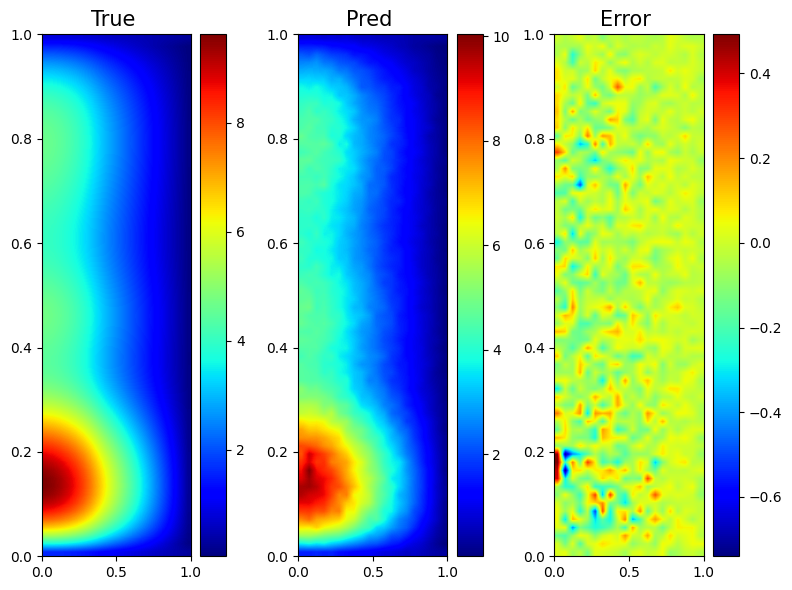

In [31]:
plot_compare_2d(data[1, -1, -1], pred[1, -1, -1])

# fuel

In [32]:
train_which = "solid"
dim = 8
emb = cond_emb(train_which, device=device)

In [33]:
cond, data = load_nt_dataset_emb(field=train_which, dataset=iter, device=device)
if model_type == "Unet":
    model = Unet3D_with_Conv3D(
        dim=dim,
        cond_dim=len(cond),
        out_dim=data.shape[1],
        cond_emb=emb,
        dim_mults=(1, 2, 4),
        use_sparse_linear_attn=False,
        attn_dim_head=16,
    ).to(device)
elif model_type == "FNO":
    model = FNO3D(
        in_channels=len(emb) + data.shape[1],
        out_channels=data.shape[1],
        nr_fno_layers=3,
        fno_layer_size=8,
        fno_modes=[6, 16, 4],
        cond_emb=emb,
        time_input=True,
    )
diffusion_fuel = GaussianDiffusion(
    model,
    seq_length=tuple(data.shape[1:]),
    timesteps=diffusion_step,
    sampling_timesteps=ddim_step,
    auto_normalize=False,
    ddim_sampling_eta=eta,
).to(device)

if model_type == "Unet":
    diffusion_fuel.load_state_dict(
        torch.load("../../results/nuclear_thermal_coupling/diffusionUnetsolid/" + iter + "_5000/model.pt")["model"],
        strict=False,
    )
else:
    diffusion_fuel.load_state_dict(
        torch.load("../../results/nuclear_thermal_coupling/diffusionFNOsolid/" + iter + "_5000/model.pt")["model"],
    )

C:\Users\taozhan\AppData\Local\Temp\ipykernel_41916\1137451280.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("../../results/nuclear_thermal_coupling/diffus

In [34]:
b = -32
for i in range(len(cond)):
    cond[i] = cond[i][b:]
data = data[b:]
with torch.no_grad():
    pred = diffusion_fuel.sample(cond[0].shape[0], cond)
    pred = renormalize(pred, "solid")
    data = renormalize(data, "solid")
    rmse = relative_error(data, pred)
    mse = F.mse_loss(pred, data)
    # print(get_relative_error(model_neu, cond, data, batchsize=32))
rmse, mse

sampling loop time step: 100%|██████████| 25/25 [00:01<00:00, 12.55it/s]


(0.029895465821027756, tensor(512.3053, device='cuda:0'))

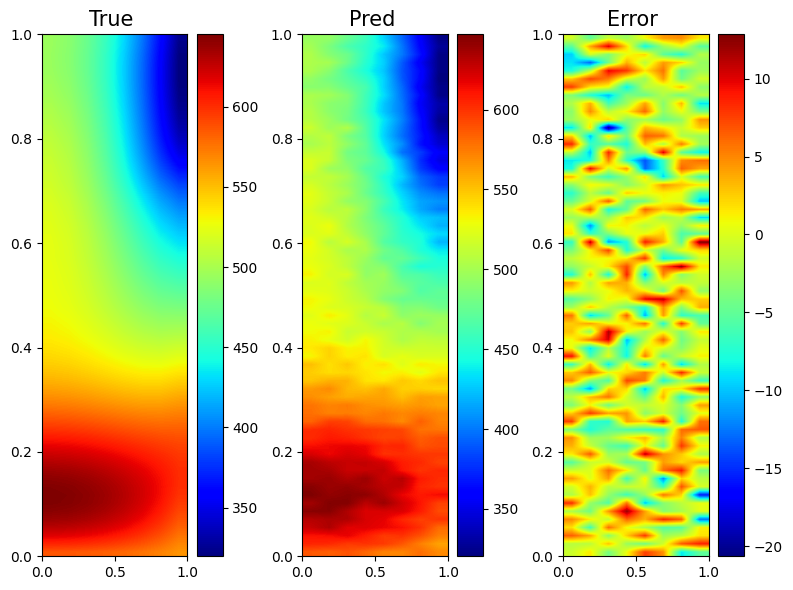

In [35]:
plot_compare_2d(data[-1, -1, 6], pred[-1, -1, 6])

# fluid

In [36]:
train_which = "fluid"
dim = 16
emb = cond_emb(train_which, device=device)

In [37]:
cond, data = load_nt_dataset_emb(field=train_which, dataset=iter, device=device)
if model_type == "Unet":

    model = Unet3D_with_Conv3D(
        dim=dim,
        cond_dim=len(cond),
        out_dim=data.shape[1],
        cond_emb=emb,
        dim_mults=(1, 2, 4),
        use_sparse_linear_attn=False,
        attn_dim_head=16,
    ).to(device)
elif model_type == "FNO":
    model = FNO3D(
        in_channels=len(emb) + data.shape[1],
        out_channels=data.shape[1],
        nr_fno_layers=3,
        fno_layer_size=16,
        fno_modes=[6, 16, 6],
        cond_emb=emb,
        time_input=True,
    )

diffusion_fluid = GaussianDiffusion(
    model,
    seq_length=tuple(data.shape[1:]),
    timesteps=diffusion_step,
    sampling_timesteps=ddim_step,
    auto_normalize=False,
    ddim_sampling_eta=eta,
).to(device)


if model_type == "Unet":
    diffusion_fluid.load_state_dict(
        torch.load("../../results/nuclear_thermal_coupling/diffusionUnetfluid/" + iter + "_5000/model.pt")["model"],
        strict=False,
    )
else:
    diffusion_fluid.load_state_dict(
        torch.load("../../results/nuclear_thermal_coupling/diffusionFNOfluid/" + iter + "_5000/model.pt")["model"],
    )

C:\Users\taozhan\AppData\Local\Temp\ipykernel_41916\1548672777.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("../../results/nuclear_thermal_coupling/diffus

In [38]:
b = -32
for i in range(len(cond)):
    cond[i] = cond[i][b:]
data = data[b:]
with torch.no_grad():
    pred = diffusion_fluid.sample(cond[0].shape[0], cond)
    pred = renormalize(pred, field="fluid")
    data = renormalize(data, field="fluid")

sampling loop time step: 100%|██████████| 25/25 [00:03<00:00,  6.35it/s]


In [39]:
loss_fluid = 0
for i in range(4):
    cu_loss = relative_error(data[:, i], pred[:, i])
    print(cu_loss)
    loss_fluid += cu_loss
relative_error(data, pred), loss_fluid / 4

0.015666142106056213
0.048082225024700165
0.13670998811721802
0.005511717405170202


(0.01818237453699112, 0.05149251816328615)

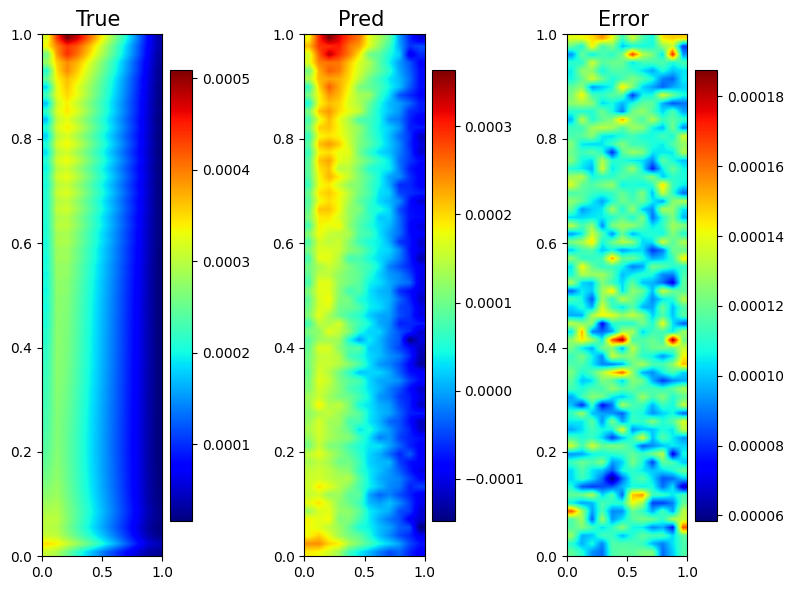

In [40]:
channel = 2
plot_compare_2d(data[-2, channel, -1], pred[-2, channel, -1])

# combine

In [41]:
def update_neu(alpha, mult_p_estimate, mult_p_estimate_before, other_condition, normalize, renormalize):
    weight_field = []
    for i in range(len(mult_p_estimate)):
        weight_field.append(alpha * mult_p_estimate[i] + (1 - alpha) * mult_p_estimate_before[i])
    T_n = torch.concat((weight_field[1], weight_field[2][:, 0:1]), dim=-1)
    (phi_bc,) = other_condition
    cond = [phi_bc, T_n]
    return cond


def update_fuel(alpha, mult_p_estimate, mult_p_estimate_before, other_condition, normalize, renormalize):
    weight_field = []
    for i in range(len(mult_p_estimate)):
        weight_field.append(alpha * mult_p_estimate[i] + (1 - alpha) * mult_p_estimate_before[i])
    neu = weight_field[0][..., :8]
    fluid_b = weight_field[2][:, 0:1, :, :, 0:1]
    cond = [neu, fluid_b]
    return cond


def k(t):
    return 17.5 * (1 - 0.223) / (1 + 0.161) + 1.54e-2 * (1 + 0.0061) / (1 + 0.161) * t + 9.38e-6 * t * t


def update_fluid(alpha, mult_p_estimate, mult_p_estimate_before, other_condition, normalize, renormalize):
    weight_field = []
    for i in range(len(mult_p_estimate)):
        weight_field.append(alpha * mult_p_estimate[i] + (1 - alpha) * mult_p_estimate_before[i])
    fuel = renormalize(weight_field[1], field="solid")
    flux = normalize((fuel[..., -2:-1] - fuel[..., -1:None]) * k(fuel[..., -1:None]), field="flux")
    cond = [flux]
    return cond

In [42]:
b = None
fuel = torch.tensor(np.load("../../data/NTcouple/val/fuel.npy")).float().to(device)[:b]
fluid = torch.tensor(np.load("../../data/NTcouple/val/fluid.npy")).float().to(device)[:b]
neu = torch.tensor(np.load("../../data/NTcouple/val/neu.npy")).float().to(device)[:b]
bc = torch.tensor(np.load("../../data/NTcouple/val/bc.npy")).float().to(device)[:b]
bc = normalize(bc, "neutron")
b = bc.shape[0]

In [43]:
if not ddim:
    mult_p = compose_diffusion(
        [diffusion_neu, diffusion_fuel, diffusion_fluid],
        [neu.shape, fuel.shape, fluid.shape],
        [update_neu, update_fuel, update_fluid],
        normalize,
        renormalize,
        [bc],
        2,
    )
else:
    mult_p = compose_diffusion_ddim(
        [diffusion_neu, diffusion_fuel, diffusion_fluid],
        [neu.shape, fuel.shape, fluid.shape],
        [update_neu, update_fuel, update_fluid],
        normalize,
        renormalize,
        [bc],
        2,
    )

sampling loop time step: 100%|██████████| 25/25 [00:23<00:00,  1.06it/s]


In [44]:
mult_p[0] = renormalize(mult_p[0], "neutron")
mult_p[1] = renormalize(mult_p[1], "solid")
mult_p[2] = renormalize(mult_p[2], "fluid")

In [45]:
mult_p[2].shape

torch.Size([64, 4, 16, 64, 12])

In [46]:
loss_fluid = 0
fluid_p = mult_p[2]
for i in range(4):
    cu_loss = relative_error(fluid[:, i], fluid_p[:, i])
    print(cu_loss)
    loss_fluid += cu_loss
loss_fluid = loss_fluid / 4
relative_error(neu, mult_p[0]), relative_error(fuel, mult_p[1]), relative_error(fluid, mult_p[2]), loss_fluid

0.06236955150961876
0.5105123519897461
1.8940542936325073
0.05159344524145126


(0.10309335589408875,
 0.144023597240448,
 0.0820314809679985,
 0.6296324105933309)

compose iter 1: 0.01997484266757965,0.039196208119392395,0.06267786026000977,0.2772705154493451  
compose iter 2: 0.020601607859134674,0.03201070800423622,0.04417296126484871;0.20663573313504457   
compose iter 3: 0.020464245229959488,0.032622046768665314, 0.04533526301383972;0.2105386178009212

In [47]:
time_step = -1

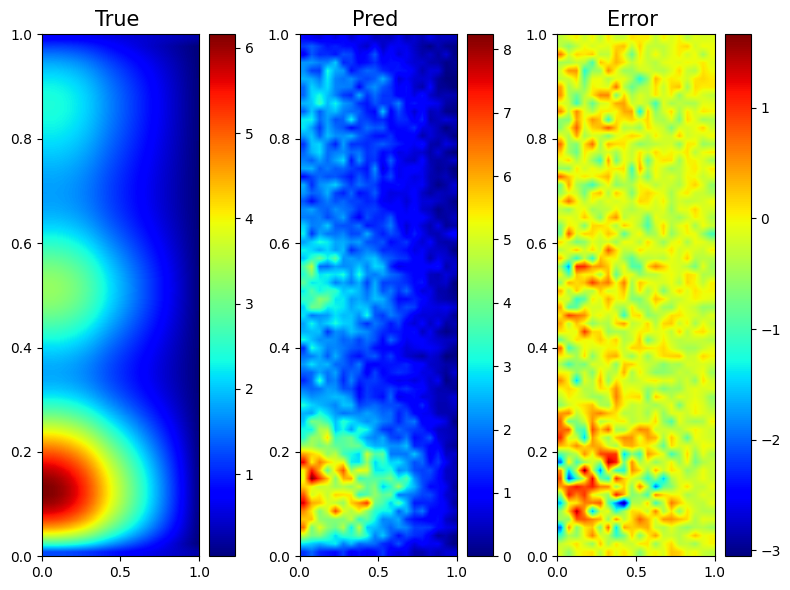

In [48]:
pred, data = mult_p[0], neu
channel = 0
plot_compare_2d(
    data[-1, channel, time_step],
    pred[-1, channel, time_step],
    savep="../../results/nuclear_thermal_coupling/neutron_diffuson" + model_type + ".png",
)

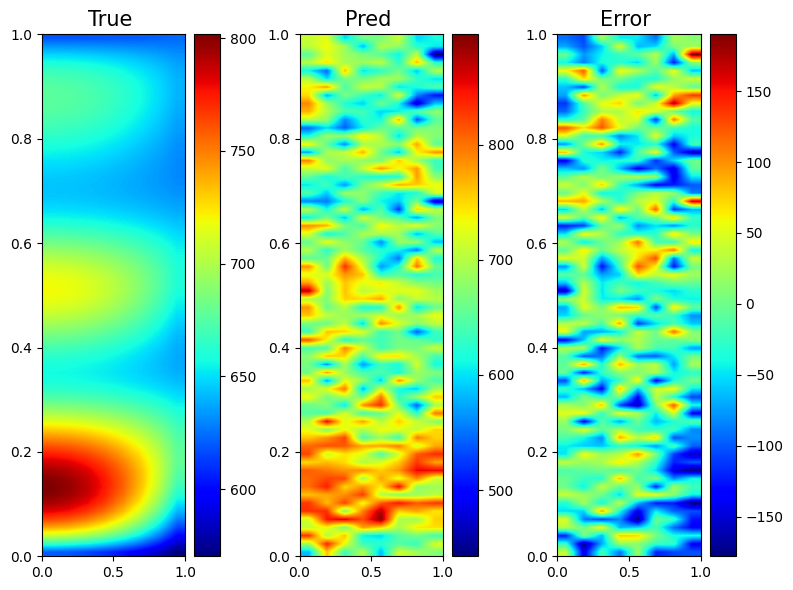

In [49]:
pred, data = mult_p[1], fuel
channel = 0
plot_compare_2d(
    data[-1, channel, time_step],
    pred[-1, channel, time_step],
    savep="../../results/nuclear_thermal_coupling/solid_diffuson" + model_type + ".png",
)

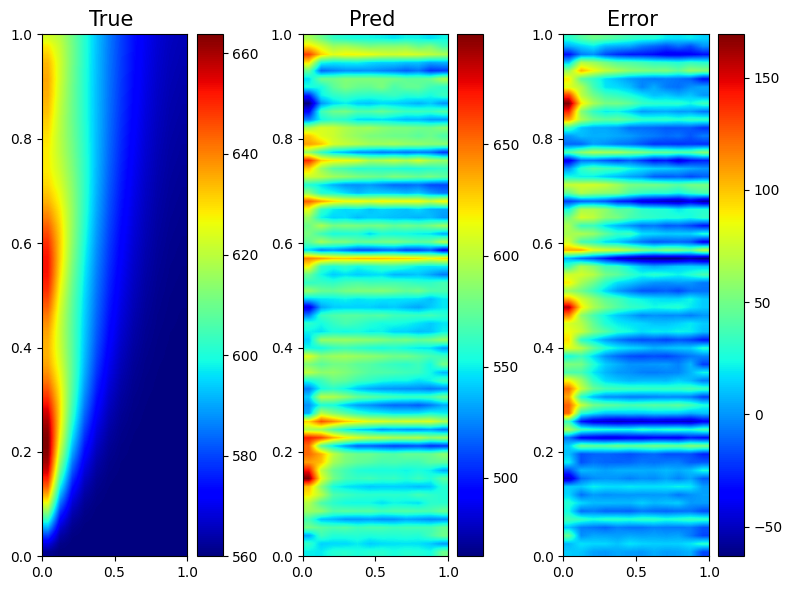

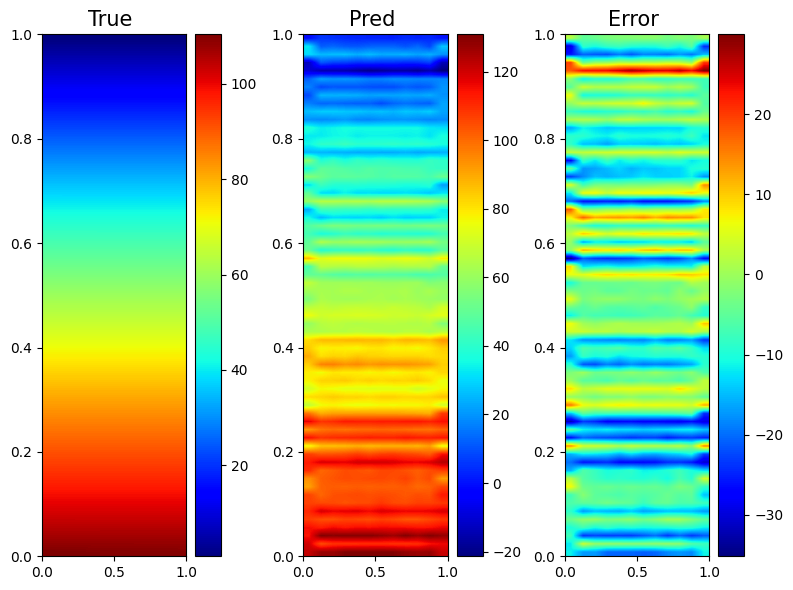

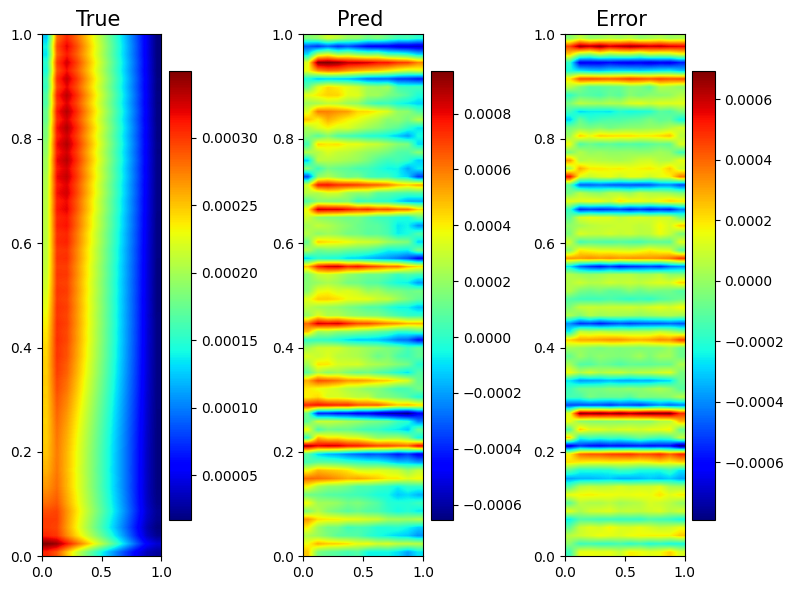

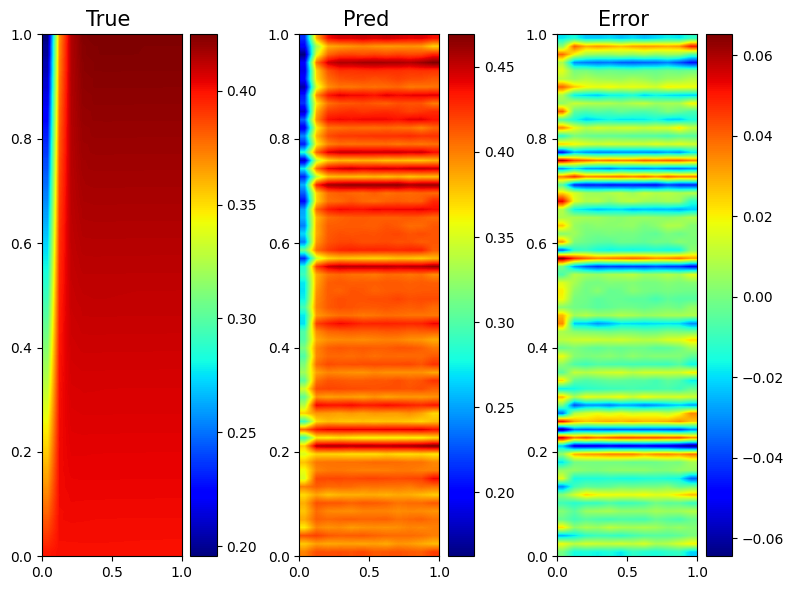

In [50]:
pred, data = mult_p[2], fluid
phy_lis = ["T", "P", "vx", "vy"]
for i in range(4):

    channel = i

    plot_compare_2d(
        data[-1, channel, time_step],
        pred[-1, channel, time_step],
        savep="../../results/nuclear_thermal_coupling/fluid" + phy_lis[i] + "_diffuson" + model_type + ".png",
    )